# Enhanced Skin Cancer Detection Using Diffusion-Based Data Augmentation and Vision Transformers

# Mounting the Drive

# Installing Libraries

In [2]:
# %pip uninstall -y torch torchvision
# %pip install torch==2.5.0 torchvision==0.20.0

In [3]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Data Preprocessing

### Import Training Data

In [4]:
csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
labels_df = pd.read_csv(csv_file, header=None, names=['image_id', 'label'])

label_map = {
    'benign': 0,
    'malignant': 1
}
labels_df['label'] = labels_df['label'].map(label_map)

image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Training_Data'
labels_df['file_path'] = labels_df['image_id'].apply(lambda x: f"{image_dir}/{x}.jpg")
labels_df.head()

,image_id,label,file_path
0,ISIC_0000000,0,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1,ISIC_0000001,0,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2,ISIC_0000002,1,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3,ISIC_0000004,1,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4,ISIC_0000006,0,datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...


### Dataset Class

In [5]:
class ISICDataset(Dataset):
    def __init__(self, labels_df, transform=None):
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = row['file_path']
        image = Image.open(img_path).convert("RGB")
        label = row['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def characterize(self):
        # Variables to store image sizes
        widths, heights = [], []
        
        # Collect sizes and class counts
        class_counts = self.labels_df['label'].value_counts()
        
        for idx, row in self.labels_df.iterrows():
            image = Image.open(row['file_path'])
            widths.append(image.size[0])
            heights.append(image.size[1])
        
        # Display Characteristics
        print(f"Dataset has {len(class_counts)} classes and {len(self.labels_df)} samples.")
        print(f"Class counts:\n{class_counts}")
       
        # Plot the distribution of image sizes as a 2D histogram
        plt.figure(figsize=(10, 6))
        plt.hist2d(widths, heights, bins=60, cmap='viridis')
        plt.colorbar(label='Number of Images')
        plt.title("Distribution of Image Sizes")
        plt.xlabel("Width (pixels)")
        plt.ylabel("Height (pixels)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

Dataset has 2 classes and 900 samples.
Class counts:
0    727
1    173
Name: label, dtype: int64


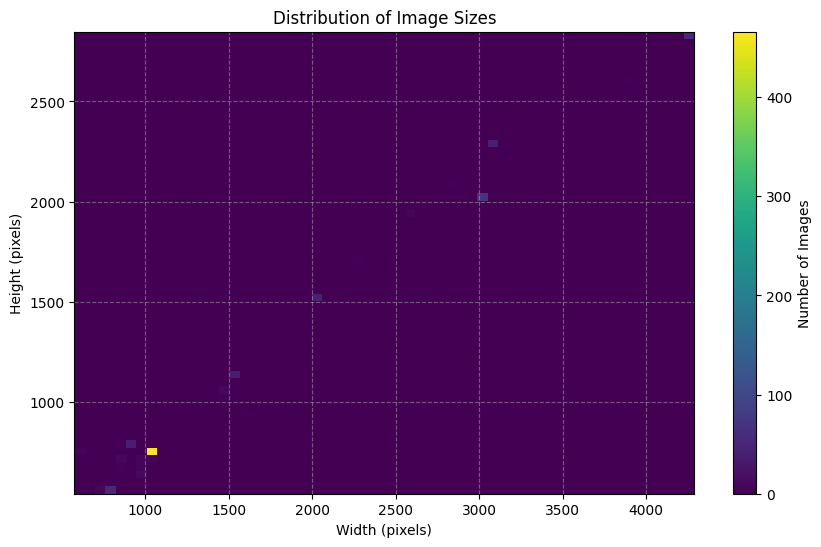

In [6]:
# Extract mean and std of RGB channels for normalization
def extract_mean_std(labels_df):
    mean = np.zeros(3)
    std = np.zeros(3)
    n_samples = len(labels_df)
    
    for idx, row in labels_df.iterrows():
        img_path = row['file_path']
        img = cv2.imread(img_path) / 255.0
        mean += np.mean(img, axis=(0, 1))
        std += np.std(img, axis=(0, 1))
        
    mean /= n_samples
    std /= n_samples
    
    return mean, std

# Hardcoded ISIC2016 for now
mean, std = [0.56719837, 0.61864448, 0.72383769], [0.15109317, 0.12867224, 0.10518483]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
])

train_dataset = ISICDataset(labels_df, transform=transform)
data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_dataset.characterize()

### Plotting Samples


TypeError: Invalid shape (3, 224, 224) for image data

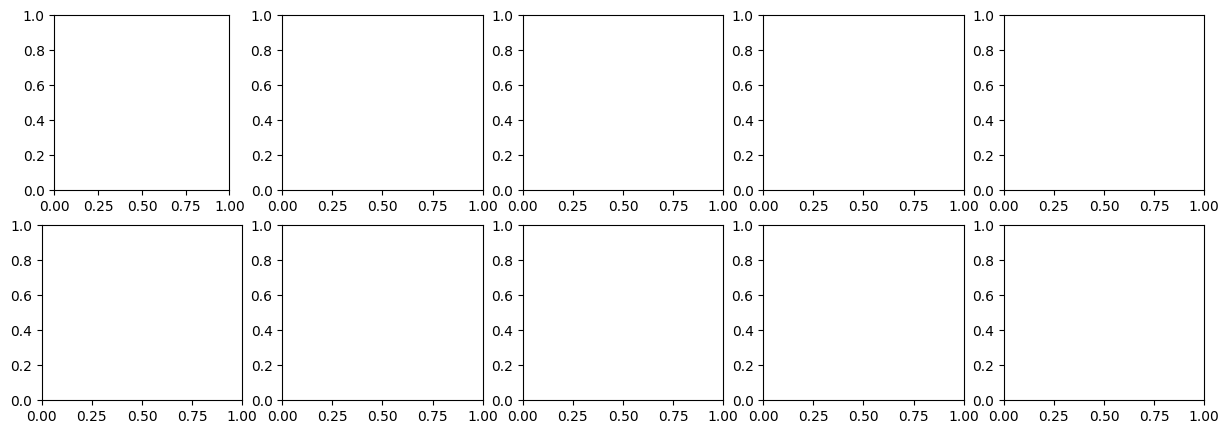

In [ ]:
def plot_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 5))
    axes = axes.flatten()
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axes[i].set_title('Malignant' if label == 1 else 'Benign')
        axes[i].axis('off')
    plt.show()

plot_samples(train_dataset)

# Diffusion-Based Augmentation

### Define Training Configuration for Diffusion-based Augmentation

In [ ]:
from dataclasses import dataclass

# TODO: change config
@dataclass
class TrainingConfig:
    image_size = 224
    train_batch_size = train_dataset.__len__()  # the batch size during training
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "no"
    output_dir = "output"  # where to store the model
    seed = 0


config = TrainingConfig()

### Model: UNet2DModel

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
# Santiy Check: Sample image size

sample_image = train_dataset[0][0].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 3, 224, 224])


### Noise Scheduler

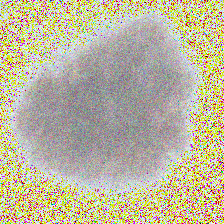

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
# Loss step

import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

print("Loss:", loss.item())

Loss: 1.0667279958724976


### Training the Diffusion Model

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(train_dataset.__len__() * config.num_epochs),
)

In [ ]:
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch
import torch.nn.functional as F

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision="no",
        cpu=True,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    
    # Create output directory if it doesn't exist
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
    
    # Prepare everything (accelerator prepares models and data loaders for distributed training)
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Training loop
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch, optionally sample demo images and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            # Save images at intervals
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            # Save model locally (skip Hugging Face Hub integration)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataset, lr_scheduler)

# notebook_launcher(train_loop, args, num_processes=1)

# Classification using Vision Transformers

### Defining the Model

In [ ]:
from torchvision import models
import torch.nn as nn

# Define a Vision Transformer model
class ViTClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(ViTClassifier, self).__init__()
        self.vit = models.vit_b_16(pretrained=pretrained)  # ViT base model
        self.vit.heads = nn.Linear(self.vit.heads.in_features, 2)  # Change output to 2 (benign vs malignant)

    def forward(self, x):
        return self.vit(x)

# Initialize the model
model = ViTClassifier(pretrained=True)


### Training Loop

In [ ]:
import torch.optim as optim
from torch import nn

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
def train_model(model, dataloaders, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels in dataloaders:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)
        
        epoch_loss = running_loss / len(dataloaders)
        epoch_accuracy = correct_preds.double() / total_preds
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
train_model(model, data_loader, num_epochs=5)
